### Metrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("creditcard.csv")[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
X = df.drop(columns=["Time", "Amount", "Class"]).values
y = df["Class"].values

f"Shapes of X={X.shape}, y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28), y=(80000,), #Fraud Cases=196'

In [4]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0: 1, 1: 2})
mod.fit(X, y).predict(X).sum()

172

In [5]:
from collections import Counter
from sklearn.ensemble import IsolationForest

mod = IsolationForest().fit(X)
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def oulier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={"contamination": np.linspace(0.001, 0.02, 10)},
    scoring={"precision": oulier_precision, "recall": outlier_recall},
    refit="precision",
    cv=5,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function oulier_precision at 0x00000149F830EDE0>,
                      'recall': <function outlier_recall at 0x00000149F830D6C0>})

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_contamination', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall'],
      dtype='object')

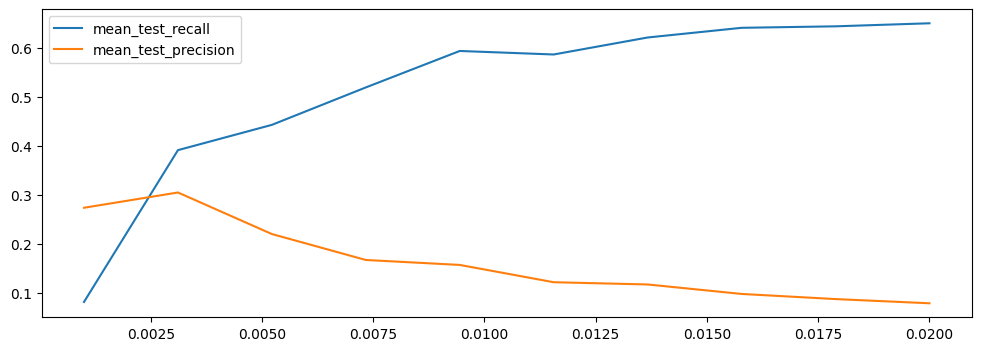

In [7]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall", "mean_test_precision"]:
    plt.plot(df_results["param_contamination"], df_results[score], label=score)
plt.legend()
df_results.keys()